# EnergyDiff

This tutorial explains how EnergyDiff works and how to use EnergyDiff to train a generative model and generate synthetic smart meter data.

---

EnergyDiff is a Denoising Diffusion Probabilistic Model(DDPM)-based model. Unlike traditional VAEs and GANs where seeds are drawn from a normal distribution and decoded through a single-pass in a Neural Network, EnergyDiff works by:
1. Training a denoising diffusion probabilistic model (DDPM) on the real data using MSE loss, which is a simplified Evidence Lower Bound.
2. During inference, draw samples from a latent isotropic Gaussian distribution and decode with the trained model by going through a series of Markovian denoising steps.
3. EnergyDiff has an additional post-processing calibration step to align the marginal distributions. 

For more information on EnergyDiff's architecture, refer to the [EnergyDiff paper](https://arxiv.org/abs/2407.13538).


### Pre-requisites

If you haven't already, please download LCL dataset from [data.london.gov.uk](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households). 


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

import logging

logger = logging.getLogger(__name__)

# 💿 Loading LCL Data

In [4]:
from pathlib import Path
from opensynth.data_modules.lcl_data_module import LCLDataModule
import pytorch_lightning as pl

import matplotlib.pyplot as plt

data_path = Path("../../data/processed/historical/train/lcl_data.csv")
stats_path = Path("../../data/processed/historical/train/mean_std.csv")
outlier_path = Path("../../data/processed/historical/train/outliers.csv")

dm = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=20000)
dm.setup()

In [5]:
dm_with_outliers = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=1024, n_samples=20000, outlier_path=outlier_path)
dm_with_outliers.setup()

# 🤖 Diffusion Module

In [6]:
from opensynth.models.energydiff import diffusion
df_model = diffusion.PLDiffusion1D(
    dim_base=128,
    dim_in=1,
    num_attn_head=4,
    num_decoder_layer=12,
    dim_feedforward=512,
    dropout=0.1,
    learn_variance=False,
    num_timestep=1000,
    model_mean_type=diffusion.ModelMeanType.V,
    model_variance_type=diffusion.ModelVarianceType.FIXED_SMALL,
    loss_type=diffusion.LossType.MSE,
    beta_schedule_type=diffusion.BetaScheduleType.COSINE,
    lr=1e-4,
    ema_update_every=1,
    ema_decay=0.999,
    disable_init_proj=False,
)

/home/nlin/.conda/envs/opensynth/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Does not support MPS when InitProjection is used.
# cuda works fine.
# suggested to use cuda to train sufficiently and effcienctly. 

trainer = pl.Trainer(
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    max_epochs=1000,
    accelerator="auto",
)
trainer.fit(df_model, dm_with_outliers)

/home/nlin/.conda/envs/opensynth/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nlin/.conda/envs/opensynth/lib/python3.11/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/nlin/.conda/envs/opensynth/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | diffusion_model | GaussianDiffusion1D | 3.7 M  | train
1 | ema             | EMA                 | 7.4 M  | train
-------------------------------------------------

Epoch 999: 100%|██████████| 19/19 [00:03<00:00,  5.74it/s, v_num=3, train_loss_step=0.440, train_loss_epoch=0.492]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 19/19 [00:03<00:00,  5.47it/s, v_num=3, train_loss_step=0.440, train_loss_epoch=0.492]


In [7]:
# Optional: load from checkpoint
df_model = diffusion.PLDiffusion1D.load_from_checkpoint('lightning_logs/version_3/checkpoints/epoch=999-step=19000.ckpt',)

### 📦 Track the training dynamics

In [28]:
import pandas as pd
# log_dir = trainer.logger.log_dir
log_dir = "lightning_logs/version_3"
metrics = pd.read_csv(f"{log_dir}/metrics.csv")
epoch_train_loss = metrics['train_loss_epoch'].dropna().values
# epoch_val_loss = metrics['val_loss'].dropna().values

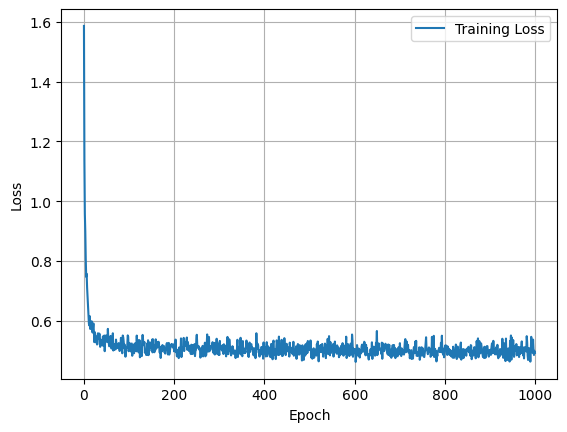

In [29]:
plt.plot(epoch_train_loss, label='Training Loss')
# plt.plot(epoch_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 📈 Comparing Results

### 0. Generating Samples

In [21]:
# sample
ema_df_model = df_model.ema.ema_model # GaussianDiffusion1D
dpm_samples = ema_df_model.dpm_solver_sample(total_num_sample=20000, batch_size=1000, step=100, shape=(48, 1))
dpm_kwh = dm_with_outliers.reconstruct_kwh(dpm_samples.squeeze(-1))
train_kwh = dm_with_outliers.reconstruct_kwh(next(iter(dm_with_outliers.train_dataloader()))['kwh'])

sampling batch 1/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.61it/s]


sampling batch 2/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.58it/s]


sampling batch 3/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.61it/s]


sampling batch 4/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.60it/s]


sampling batch 5/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.60it/s]


sampling batch 6/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.61it/s]


sampling batch 7/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.60it/s]


sampling batch 8/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.57it/s]


sampling batch 9/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.56it/s]


sampling batch 10/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.57it/s]


sampling batch 11/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.58it/s]


sampling batch 12/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.58it/s]


sampling batch 13/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.59it/s]


sampling batch 14/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.60it/s]


sampling batch 15/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.59it/s]


sampling batch 16/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.59it/s]


sampling batch 17/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.59it/s]


sampling batch 18/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.59it/s]


sampling batch 19/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.59it/s]


sampling batch 20/20, batch size 1000. 


multistep_dpm_solver_update: 100%|██████████| 98/98 [00:04<00:00, 20.60it/s]


In [22]:
# calibration
import torch
from opensynth.models.energydiff import calibrate
dpm_kwh_calib = torch.tensor(calibrate.calibrate(train_kwh, dpm_kwh).to('cpu'))

/tmp/ipykernel_1848944/2689047756.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dpm_kwh_calib = torch.tensor(calibrate.calibrate(train_kwh, dpm_kwh).to('cpu'))


In [23]:
# Optional: save samples
os.makedirs('lightning_logs/version_3/samples', exist_ok=True)
torch.save(dpm_kwh_calib, 'lightning_logs/version_3/samples/dpm_kwh_calib.pt')

In [ ]:
# Optional: load samples
dpm_kwh_calib = torch.load('lightning_logs/version_3/samples/dpm_kwh_calib.pt')

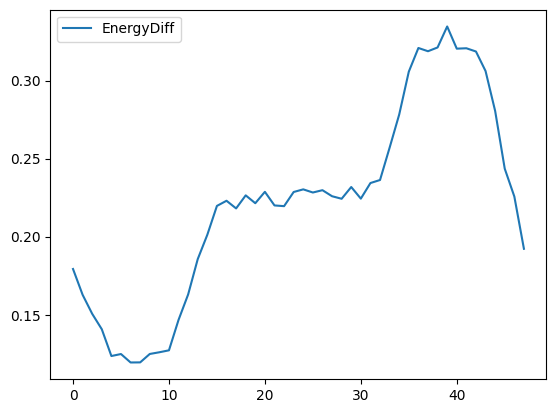

In [24]:
plt.plot(dpm_kwh_calib.mean(dim=0).cpu().numpy(), label='EnergyDiff')
plt.legend()
plt.show()

In [13]:
gmm_data_module = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=5000, n_samples=50000, outlier_path=outlier_path) # just to be consistent with Faraday notebook
gmm_data_module.setup()
real_kwh = dm.reconstruct_kwh(next(iter(gmm_data_module.train_dataloader()))['kwh'])
real_kwh = torch.clip(real_kwh, min=0) # Clip min 0 to get read of negative values

### 1. Comparing mean, 95th quantile, median profiles

In [14]:
def plot_stats(real_kwh, gmm_reconstruct):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3), sharey=True, gridspec_kw={'wspace': 0.05})

    ax1.plot(real_kwh.mean(dim=0).detach().numpy(), label="real kwh")
    ax1.plot(gmm_reconstruct.mean(dim=0).detach().numpy(), label="energydiff kwh")
    ax1.set_title("Mean kWh per half hour")
    ax1.set_xlabel("Settlement Periods")
    ax1.legend()

    ax2.plot(real_kwh.quantile(0.95, dim=0).detach().numpy(), label="real kwh")
    ax2.plot(gmm_reconstruct.quantile(0.95, dim=0).detach().numpy(), label="energydiff kwh")
    ax2.set_title("95th Quantile kWh per half hour")
    ax2.set_xlabel("Settlement Periods")
    ax2.legend()

    ax3.plot(real_kwh.quantile(0.5, dim=0).detach().numpy(), label="real kwh")
    ax3.set_title("Median kWh per half hour")
    ax3.set_xlabel("Settlement Periods")
    ax3.plot(gmm_reconstruct.quantile(0.5, dim=0).detach().numpy(), label="energydiff kwh")
    ax3.legend()

    fig.text(0.1, 0.5, 'kWh', va='center', rotation='vertical')

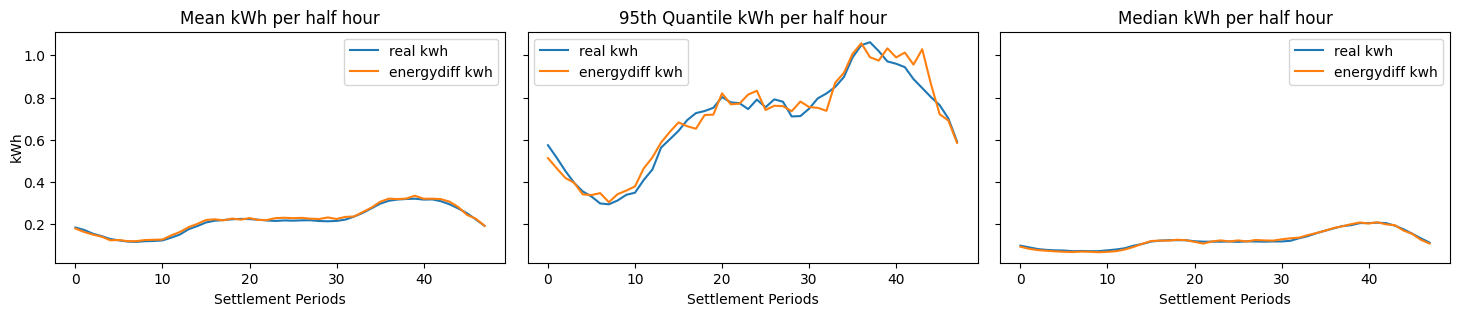

In [25]:
plot_stats(real_kwh, dpm_kwh_calib)

### 2. PCA and TSNE Distribution Plots

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np


def train_pca_and_tsne(real_kwh, gmm_reconstruct):
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2)

    pca.fit(real_kwh.detach().numpy())
    pca_real = pca.transform(real_kwh.detach().numpy())
    pca_gmm = pca.transform(gmm_reconstruct.detach().numpy())

    tsne_input = np.concatenate([real_kwh.detach().numpy(), gmm_reconstruct.detach().numpy()])
    tsne_results = tsne.fit_transform(tsne_input)
    tsne_real = tsne_results[:len(real_kwh)]
    tsne_gmm = tsne_results[len(real_kwh):]

    return pca_real, pca_gmm, tsne_real, tsne_gmm


def plot_pca_tsne(pca_real, pca_gmm, tsne_real, tsne_gmm):
    fig, (ax_pca, ax_tsne) = plt.subplots(1, 2, figsize=(12, 4))

    ax_pca.scatter(pca_real[:, 0], pca_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_pca.scatter(pca_gmm[:, 0], pca_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.5)
    ax_pca.set_title("PCA")
    ax_pca.set_xlabel("PCA 1")
    ax_pca.set_ylabel("PCA 2")
    ax_pca.legend()

    ax_tsne.scatter(tsne_real[:, 0], tsne_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_tsne.scatter(tsne_gmm[:, 0], tsne_gmm[:, 1], label="energydiff kwh", s=0.3, alpha=0.5)
    ax_tsne.set_title("TSNE")
    ax_tsne.set_xlabel("TSNE 1")
    ax_tsne.set_ylabel("TSNE 2")
    ax_tsne.legend()
    return fig


Text(0.5, 1.0, 'EnergyDiff')

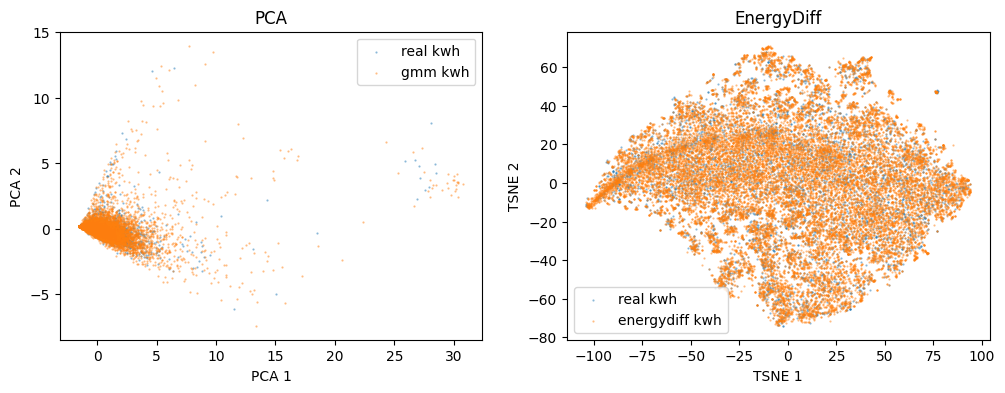

In [27]:
a1, a2, a3, a4 = train_pca_and_tsne(real_kwh, dpm_kwh_calib)
_ = plot_pca_tsne(a1, a2, a3, a4)
plt.title("EnergyDiff")